In [14]:
from fastai.vision.all import *
import os

In [15]:
path = Path("/data/datasets/severstal")

In [3]:
Path.BASE_PATH = path

In [4]:
path.ls()

(#7) [Path('severstal-steel-defect-detection.zip'),Path('codes.txt'),Path('sample_submission.csv'),Path('test_images'),Path('train.csv'),Path('train_images'),Path('masks')]

In [5]:
df = pd.read_csv(path/'train.csv')

In [7]:
fnames=get_image_files(path/'train_images')

<AxesSubplot:>

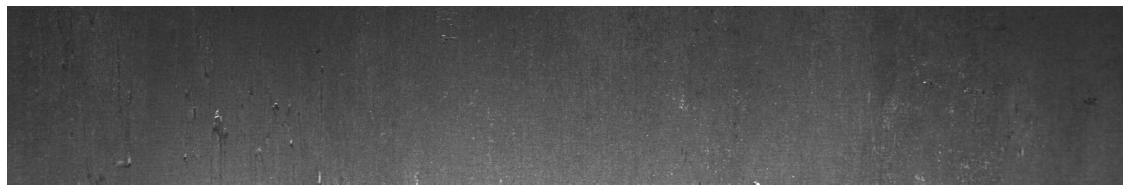

In [8]:
im = PILImage.create(fnames[5])
im.show(figsize=(20,5))

In [9]:
get_mask = lambda o: path/f'masks/{o.stem}.png'

<AxesSubplot:>

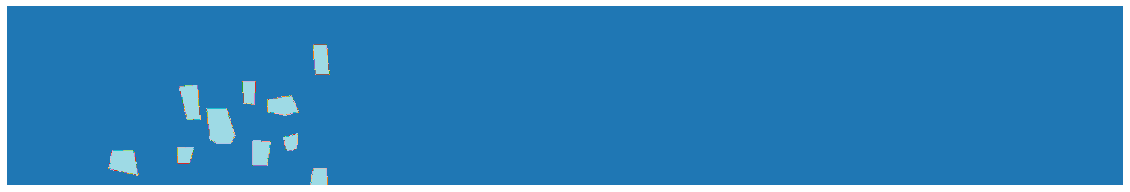

In [10]:
msk = PILMask.create(get_mask(fnames[5]))
msk.show(figsize=(20,5), alpha=1)

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Background', 'Divots', 'Cracks', 'Scratches', 'Ablation'],
      dtype='<U10')

# Transfer learning

## Progressive Resizing

First quarter, then half and quarter to and finally full image size

In [12]:
sz = msk.shape; sz

(256, 1600)

In [13]:
qtr_sz = tuple(x//4 for x in sz); qtr_sz

(64, 400)

In [14]:
dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                     get_items = get_image_files,
                     splitter=RandomSplitter(valid_pct=0.2, seed=42),
                     get_y = get_mask,
                     item_tfms = RandomResizedCrop(qtr_sz, min_scale=0.7),
                     batch_tfms=Normalize.from_stats(*imagenet_stats)
                     )

In [15]:
dls = dblock.dataloaders(path/'train_images', bs=1)

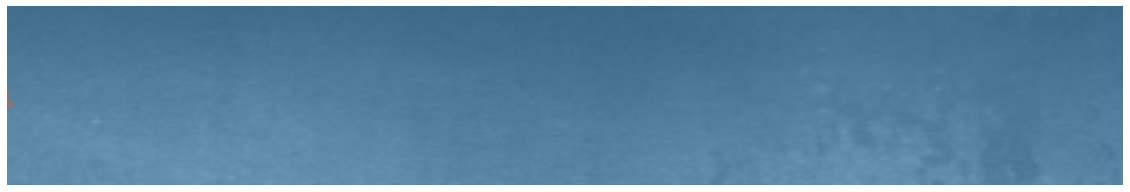

In [16]:
dls.show_batch(max_n=1, nrows=1, vmin=1, vmax=5, figsize=(20,5))

In [17]:
dls.vocab = codes

In [18]:
name2id = {k:v for k,v in enumerate(codes)}
name2id

{0: 'Background', 1: 'Divots', 2: 'Cracks', 3: 'Scratches', 4: 'Ablation'}

In [19]:
void_code='Background'

In [20]:
def acc_severstal(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

# Training Model

In [21]:
opt = ranger

In [22]:
learn = unet_learner(dls, resnet34, metrics=acc_severstal, self_attention=True, act_cls=Mish, opt_func=opt)

In [23]:
learn.summary()

DynamicUnet (Input shape: 1)
Layer (type)         Output Shape         Param #    Trainable 
                     1 x 64 x 32 x 200   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=0.0005754399462603033)

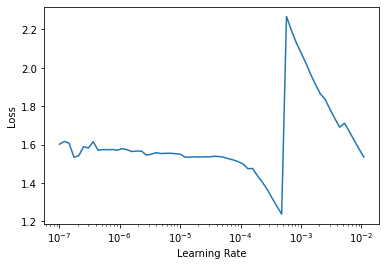

In [24]:
learn.lr_find()

In [25]:
lr = 1e-4

In [26]:
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,acc_severstal,time
0,0.079091,0.183208,0.937657,09:31
1,0.051030,0.197822,0.946199,09:14
2,0.056064,0.224194,0.948254,09:15
3,0.052183,0.259629,0.927756,09:36
4,0.038847,0.484729,0.957379,09:42
5,0.026051,0.477455,0.946027,09:30
6,0.014653,0.853880,0.952373,09:43
7,0.024665,0.347615,0.929541,09:14
8,0.021062,0.580270,0.934355,09:44
9,0.014648,0.620127,0.938532,09:47


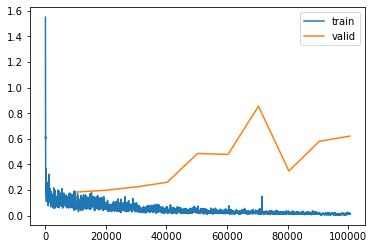

In [27]:
learn.recorder.plot_loss()

In [28]:
learn.save('stage-1')

Path('models/stage-1.pth')

In [29]:
learn.load('stage-1')

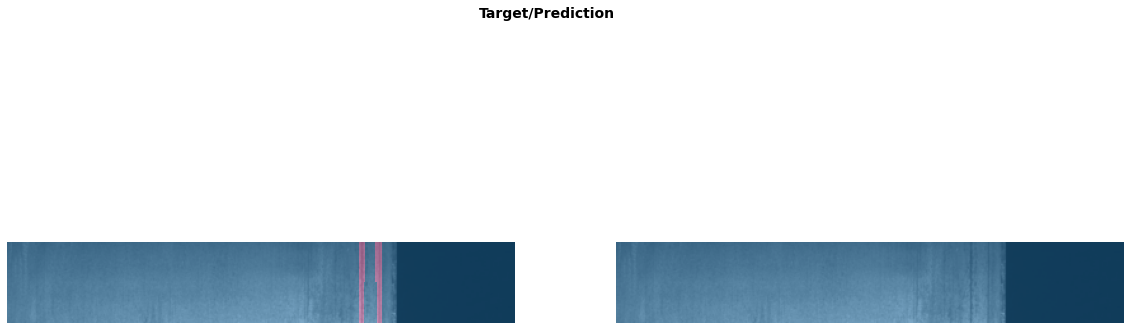

In [30]:
learn.show_results(max_n=1, figsize=(20,8))

In [31]:
lrs = slice(lr/400, lr/4)

In [32]:
lr, lrs

(0.0001, slice(2.5e-07, 2.5e-05, None))

In [33]:
learn.unfreeze()

In [34]:
learn.fit_flat_cos(12, lrs)

epoch,train_loss,valid_loss,acc_severstal,time
0,0.010804,0.631797,0.946694,10:38
1,0.008594,0.532071,0.955212,10:30
2,0.011429,0.617402,0.939875,10:17
3,0.004929,0.748638,0.945397,10:28
4,0.006994,0.849066,0.947196,10:39
5,0.007312,0.693496,0.947964,10:21
6,0.004214,1.184553,0.943294,10:34
7,0.006719,1.215932,0.946003,11:00
8,0.003412,0.881229,0.953289,10:45
9,0.003687,0.775109,0.950068,10:41


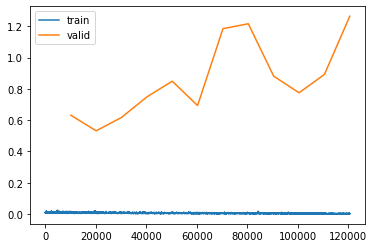

In [35]:
learn.recorder.plot_loss()

In [36]:
learn.save('model_1')

Path('models/model_1.pth')

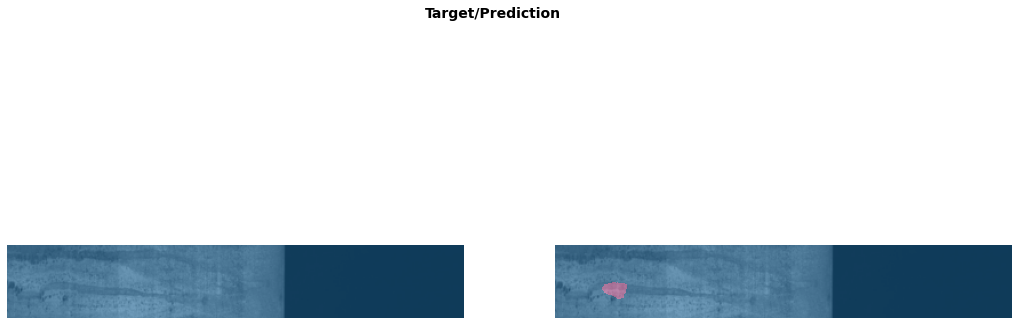

In [37]:
learn.show_results(max_n=4, figsize=(18,8))

# Inference

In [38]:
fnames_test = get_image_files(path/'test_images')
dl = learn.dls.test_dl(fnames_test[:5])

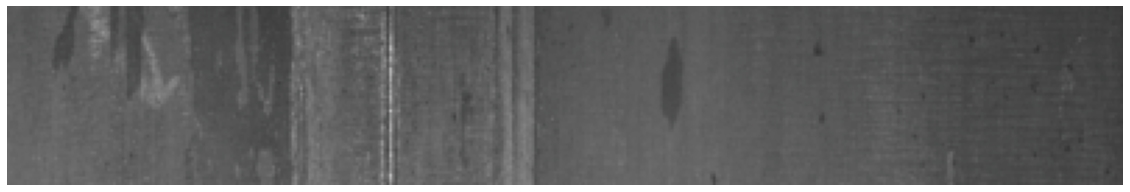

In [39]:
dl.show_batch(figsize=(20,10))

In [40]:
preds = learn.get_preds(dl=dl)

In [41]:
preds[0].shape

torch.Size([5, 5, 64, 400])

In [42]:
len(codes)

5

In [43]:
pred_1 = preds[0][0]

In [44]:
pred_1.shape

torch.Size([5, 64, 400])

In [45]:
pred_arx = pred_1.argmax(dim=0)

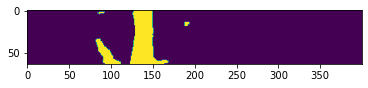

In [46]:
plt.imshow(pred_arx)

In [47]:
pred_arx = pred_arx.numpy()

In [48]:
rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)

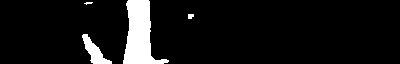

In [49]:
im = Image.fromarray(rescaled)
im

# Half size

In [1]:
from fastai.vision.all import *

In [2]:
path = Path("/data/datasets/severstal")
get_mask = lambda o: path/f'masks/{o.stem}.png'
codes = np.loadtxt(path/'codes.txt', dtype=str)
name2id = {k:v for k,v in enumerate(codes)}
void_code='Background'
msk = PILMask.create((path/'train_images').ls().sorted()[1])
sz = msk.shape
half = tuple(x//2 for x in sz)

def acc_severstal(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

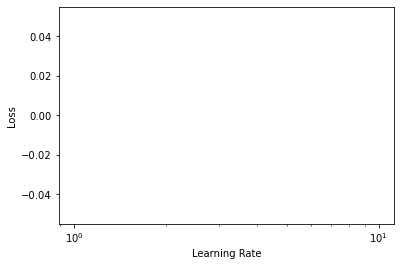

In [3]:
dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                     get_items = get_image_files,
                     splitter=RandomSplitter(valid_pct=0.2, seed=42),
                     get_y = get_mask,
                     item_tfms = RandomResizedCrop(half, min_scale=0.7),
                     batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

dls = dblock.dataloaders(path/'train_images', bs=1)

opt = ranger

dls.vocab = codes
learn = unet_learner(dls, resnet34, metrics=acc_severstal, self_attention=True, act_cls=Mish, opt_func=opt)
learn.load('model_1');

learn.lr_find()

In [4]:
lr = 1e-6

In [6]:
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,acc_severstal,time
0,0.095703,0.309326,0.913144,15:09
1,0.083452,0.347650,0.883516,15:08
2,0.111086,0.278549,0.908135,15:05
3,0.073347,0.285126,0.900871,15:10
4,0.083817,0.347974,0.882980,15:15
5,0.073154,0.254856,0.925937,15:14
6,0.063425,0.423989,0.840603,15:15
7,0.054705,0.337181,0.885334,15:18
8,0.074046,0.264303,0.930591,15:19
9,0.052304,0.391188,0.868410,15:18


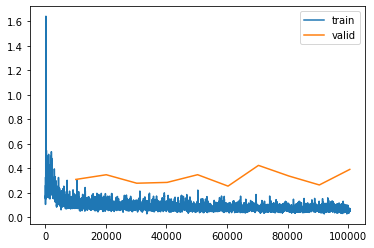

In [7]:
learn.recorder.plot_loss()

In [8]:
learn.save('half_1')

Path('models/half_1.pth')

In [5]:
learn.unfreeze()
lrs = slice(1e-6,lr/10)
learn.fit_flat_cos(10, lrs)

epoch,train_loss,valid_loss,acc_severstal,time
0,0.080784,0.446894,0.849903,16:48
1,0.045457,0.318102,0.913526,16:51
2,0.060841,0.313827,0.921563,16:50
3,0.040073,0.564418,0.833498,16:51
4,0.039657,0.458084,0.866266,16:52
5,0.083523,0.429916,0.881331,16:49
6,0.038456,0.445920,0.866358,16:39
7,0.065512,0.377017,0.917411,16:43
8,0.038215,0.519891,0.862290,16:51
9,0.042231,0.376322,0.924016,16:48


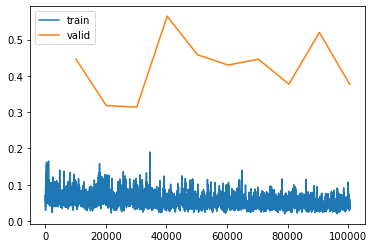

In [6]:
learn.recorder.plot_loss()

In [7]:
learn.save('half_2')

Path('models/half_2.pth')

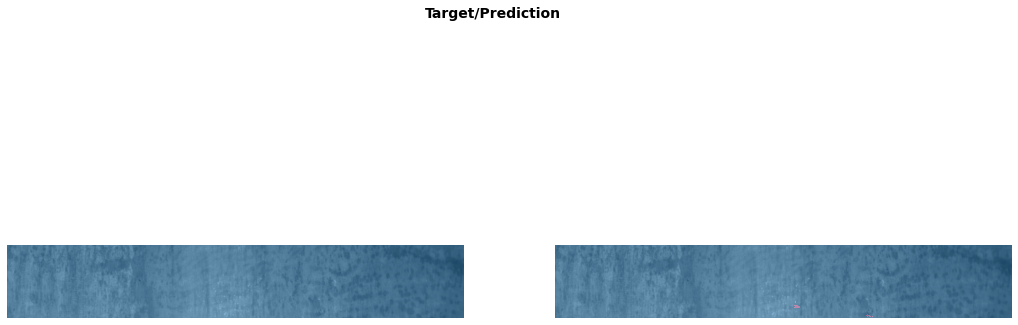

In [8]:
learn.show_results(max_n=4, figsize=(18,8))

# Full size

In [1]:
from fastai.vision.all import *

In [2]:
torch.cuda.set_device(3)

In [3]:
path = Path("/data/datasets/severstal")
get_mask = lambda o: path/f'masks/{o.stem}.png'
codes = np.loadtxt(path/'codes.txt', dtype=str)
name2id = {k:v for k,v in enumerate(codes)}
void_code='Background'
msk = PILMask.create((path/'train_images').ls().sorted()[1])
sz = msk.shape

def acc_severstal(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [4]:
dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                     get_items = get_image_files,
                     splitter=RandomSplitter(valid_pct=0.2, seed=42),
                     get_y = get_mask,
                     item_tfms = RandomResizedCrop(sz, min_scale=0.7),
                     batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

dls = dblock.dataloaders(path/'train_images', bs=1)

opt = ranger

dls.vocab = codes
learn = unet_learner(dls, resnet34, metrics=acc_severstal, self_attention=True, act_cls=Mish, opt_func=opt)
learn.load('half_2');


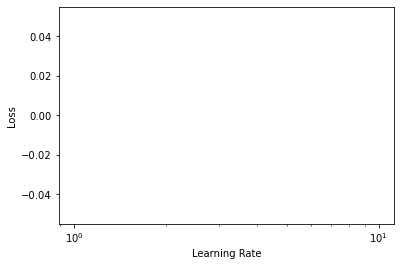

In [5]:
learn.lr_find()

In [6]:
lr = 1e-3

In [7]:
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,acc_severstal,time
0,0.096575,0.462522,0.769378,51:05
1,0.158713,0.409812,0.884510,50:49
2,0.087547,1.380579,0.439466,50:42
3,0.072743,0.472970,0.801019,50:46
4,0.100021,4.587691,0.260217,50:40
5,0.068132,1.671277,0.437283,50:34
6,0.097131,1.099077,0.620297,50:25
7,0.085338,1.047891,0.682640,50:19
8,0.062360,0.506522,0.850807,50:17
9,0.036675,0.843374,0.768599,50:20


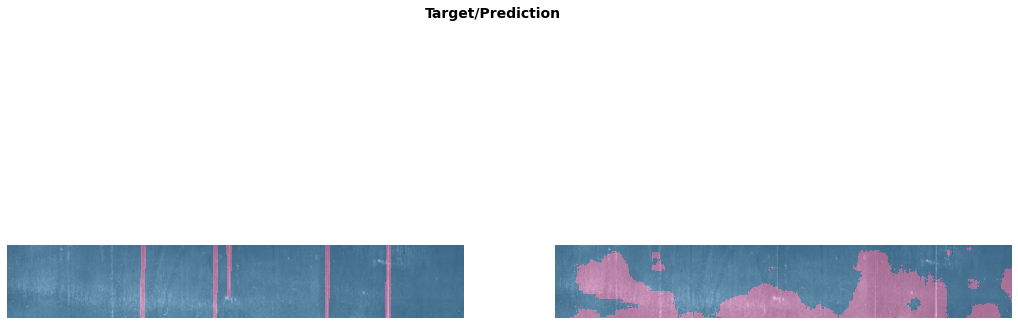

In [8]:
learn.show_results(max_n=4, figsize=(18,8))

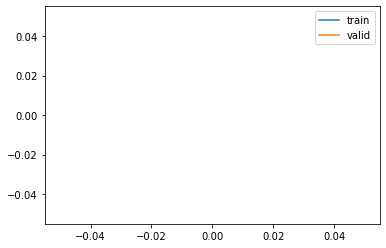

In [9]:
learn.recorder.plot_loss()

In [10]:
learn.save('full_1')

Path('models/full_1.pth')

In [11]:
learn.unfreeze()
lrs = slice(1e-6,lr/10)
learn.fit_flat_cos(10, lrs)

epoch,train_loss,valid_loss,acc_severstal,time
0,0.040237,2.500132,0.483661,52:49
1,0.036638,1.768265,0.657136,52:51
2,0.019454,2.362330,0.603974,52:50
3,0.019423,2.779905,0.567671,52:47
4,0.024333,1.944035,0.657818,52:49
5,0.018222,3.163896,0.591086,52:50
6,0.016171,1.410842,0.748527,52:48
7,0.022023,3.631452,0.531204,52:48
8,0.026327,3.336784,0.574719,52:48
9,0.016081,2.147622,0.702729,52:49


In [12]:
learn.save('full_2')

Path('models/full_2.pth')

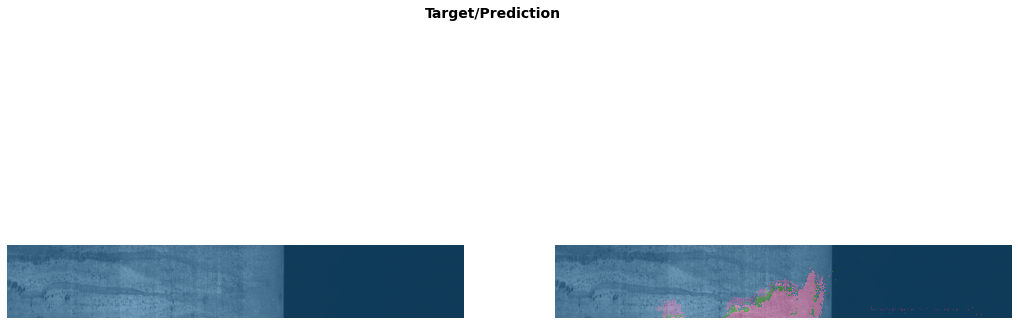

In [13]:
learn.show_results(max_n=4, figsize=(18,8))